<a href="https://colab.research.google.com/github/hei1sme/DynamicLaneBarriers/blob/main/notebook/%5BDLB%5D_DATA_PREPROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Traffic Data Preprocessing for Dynamic Traffic Management***



## ***I. Import Libraries***

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up display options for better visualization
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

## ***II. Import Dataset***

In [68]:
# URL for the traffic dataset
url = "https://raw.githubusercontent.com/hei1sme/DynamicLaneBarriers/refs/heads/main/data/raw/traffic_historical_unprocessed_data.csv"

# Load the data
df = pd.read_csv(url)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")
df.head()

Dataset shape: (75655, 7)
Number of rows: 75655
Number of columns: 7
Time range: 2025-02-21 07:48:09 to 2025-03-10 14:27:04
Duration: 17 days 06:38:55


,timestamp,low_inbound,medium_inbound,high_inbound,low_outbound,medium_outbound,high_outbound
0,2025-02-21 07:48:09,0.000827,0.058200,0.940973,0.989017,0.008932,0.002052
1,2025-02-21 07:48:19,0.000412,0.033646,0.965942,0.996076,0.002788,0.001136
2,2025-02-21 07:48:29,0.003714,0.266212,0.730074,0.261669,0.670311,0.068020
3,2025-02-21 07:48:44,0.001004,0.063582,0.935414,0.690030,0.267154,0.042816
4,2025-02-21 07:48:54,0.059059,0.780722,0.160218,0.929662,0.041504,0.028834


## ***III. Data Quality Assessment***

In [69]:
# 2.1: Check data types and null values
print("Data Types and Null Values Summary:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found")

# Basic statistics
print("\nBasic Statistics:")
display(df.describe())

Data Types and Null Values Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75655 entries, 0 to 75654
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        75655 non-null  datetime64[ns]
 1   low_inbound      75655 non-null  float64       
 2   medium_inbound   75655 non-null  float64       
 3   high_inbound     75655 non-null  float64       
 4   low_outbound     75655 non-null  float64       
 5   medium_outbound  75655 non-null  float64       
 6   high_outbound    75655 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 4.0 MB
None

Missing Values:
No missing values found

Basic Statistics:


,timestamp,low_inbound,medium_inbound,high_inbound,low_outbound,medium_outbound,high_outbound
count,75655,75655.000000,75655.000000,7.565500e+04,75655.000000,75655.000000,75655.000000
mean,2025-03-02 07:35:40.411301376,0.381728,0.389699,2.285727e-01,0.797505,0.123184,0.079311
min,2025-02-21 07:48:09,0.000158,0.000128,8.511398e-07,0.000573,0.000067,0.000119
25%,2025-02-25 21:59:14,0.015780,0.086935,9.823359e-03,0.767625,0.002542,0.001117
50%,2025-03-02 12:22:29,0.129890,0.365316,7.149505e-02,0.986110,0.009508,0.003221
75%,2025-03-06 09:46:09,0.872943,0.691067,3.958947e-01,0.996068,0.096158,0.020538
max,2025-03-10 14:27:04,0.999871,0.865956,9.867835e-01,0.999785,0.973052,0.994508
std,NaN,0.407189,0.297211,2.893516e-01,0.331715,0.232502,0.205352


In [70]:
# 2.2: Examine timestamp data
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Check the time range
print(f"\nTime Range:")
print(f"Start: {df['timestamp'].min()}")
print(f"End: {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")

# Check time intervals
df_sorted = df.sort_values('timestamp')
time_diffs = df_sorted['timestamp'].diff()
print(f"\nTime Intervals:")
print(f"Min interval: {time_diffs.min()}")
print(f"Max interval: {time_diffs.max()}")
print(f"Mean interval: {time_diffs.mean()}")
print(f"Median interval: {time_diffs.median()}")

# Check for duplicates
duplicates = df['timestamp'].duplicated()
print(f"\nDuplicates:")
print(f"Number of duplicate timestamps: {duplicates.sum()}")


Time Range:
Start: 2025-02-21 07:48:09
End: 2025-03-10 14:27:04
Duration: 17 days 06:38:55

Time Intervals:
Min interval: 0 days 00:00:00
Max interval: 0 days 07:27:59
Mean interval: 0 days 00:00:19.731078330
Median interval: 0 days 00:00:10

Duplicates:
Number of duplicate timestamps: 1


In [71]:
# 2.3: Check data normalization
# Check if traffic values are normalized (sum to 1 for each direction)
traffic_cols = ['low_inbound', 'medium_inbound', 'high_inbound',
               'low_outbound', 'medium_outbound', 'high_outbound']

df['inbound_sum'] = df['low_inbound'] + df['medium_inbound'] + df['high_inbound']
df['outbound_sum'] = df['low_outbound'] + df['medium_outbound'] + df['high_outbound']

print("\nNormalization Check:")
print(f"Inbound sum stats: min={df['inbound_sum'].min()}, max={df['inbound_sum'].max()}, mean={df['inbound_sum'].mean()}")
print(f"Outbound sum stats: min={df['outbound_sum'].min()}, max={df['outbound_sum'].max()}, mean={df['outbound_sum'].mean()}")

# Should be close to 1.0 if already normalized
is_normalized = (0.99 <= df['inbound_sum'].mean() <= 1.01) and (0.99 <= df['outbound_sum'].mean() <= 1.01)
print(f"Data appears to be {'normalized' if is_normalized else 'not normalized'}")


Normalization Check:
Inbound sum stats: min=0.9999998395699999, max=1.0000001624000001, mean=1.0000000000384468
Outbound sum stats: min=0.9999998274999999, max=1.00000016, mean=0.9999999996481883
Data appears to be normalized


Found 71 gaps larger than 60 seconds

Largest gaps:
2025-02-21 17:32:54: 447.98 minutes
2025-02-26 05:01:12: 421.30 minutes
2025-03-05 05:01:11: 421.30 minutes
2025-03-07 05:01:11: 421.15 minutes
2025-03-02 05:00:34: 420.67 minutes


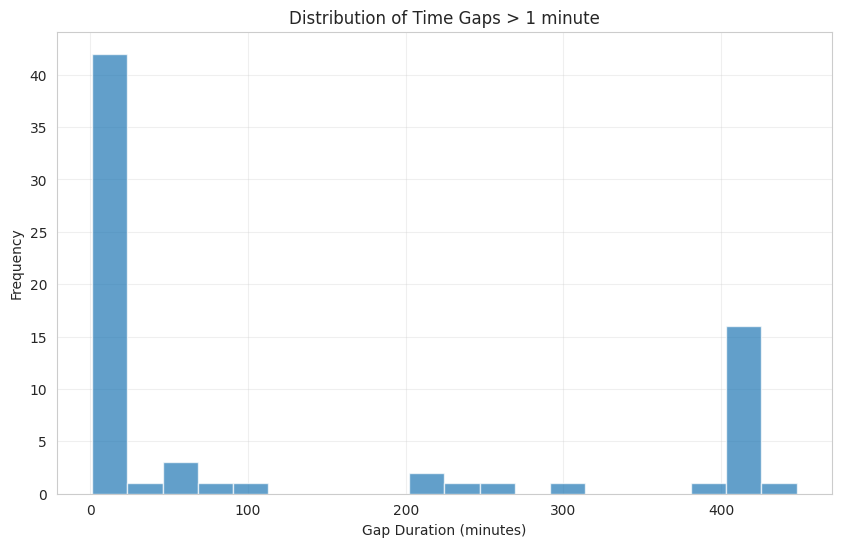

In [72]:
# 2.4: Check for time gaps and discontinuities
# Create a copy with timestamp as index
data_indexed = df.copy()
data_indexed.set_index('timestamp', inplace=True)

time_diffs_seconds = data_indexed.index.to_series().diff().dt.total_seconds()
large_gaps = time_diffs_seconds[time_diffs_seconds > 60]  # Gaps larger than 1 minute

if len(large_gaps) > 0:
    print(f"Found {len(large_gaps)} gaps larger than 60 seconds")
    print("\nLargest gaps:")
    largest_gaps = large_gaps.nlargest(5)
    for time, gap in largest_gaps.items():
        print(f"{time}: {gap/60:.2f} minutes")

    # Plot the distribution of gaps
    plt.figure(figsize=(10, 6))
    plt.hist(large_gaps/60, bins=20, alpha=0.7)
    plt.xlabel('Gap Duration (minutes)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time Gaps > 1 minute')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No significant time gaps found")


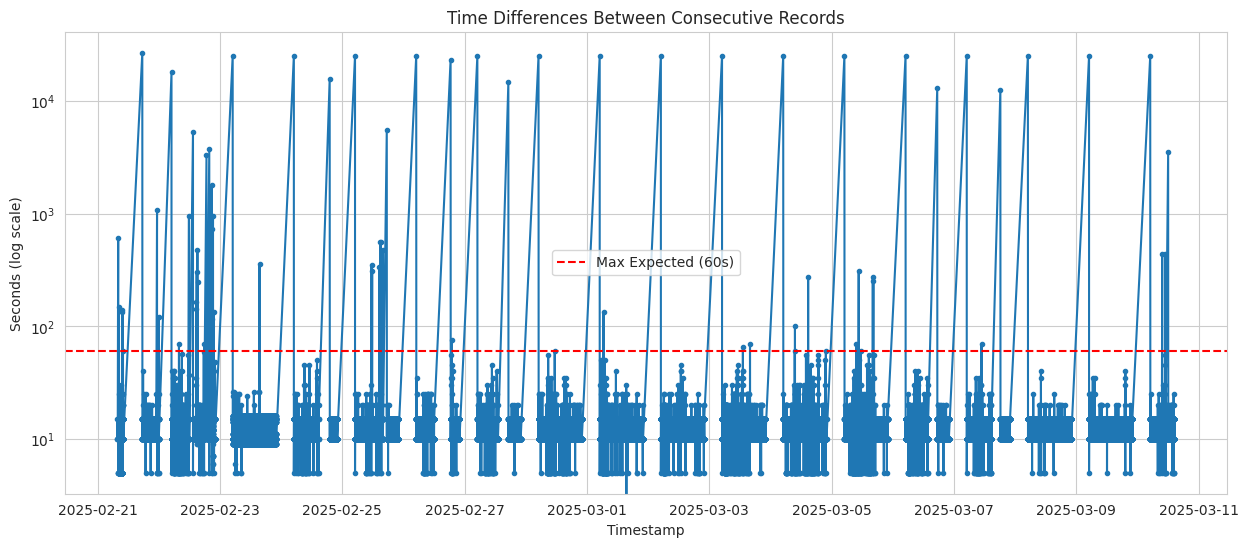

In [73]:
# Time series continuity check - looking for gaps in the data
df.set_index('timestamp', inplace=True)
time_diffs = df.index.to_series().diff().dt.total_seconds()
max_expected_diff = 60  # Assuming we expect data every minute or less

# Plot time differences
plt.figure(figsize=(15, 6))
plt.plot(df.index[1:], time_diffs[1:], 'o-', markersize=3)
plt.axhline(y=max_expected_diff, color='r', linestyle='--', label=f'Max Expected ({max_expected_diff}s)')
plt.yscale('log')  # Use log scale to better visualize the differences
plt.title('Time Differences Between Consecutive Records')
plt.xlabel('Timestamp')
plt.ylabel('Seconds (log scale)')
plt.grid(True)
plt.legend()
plt.show()

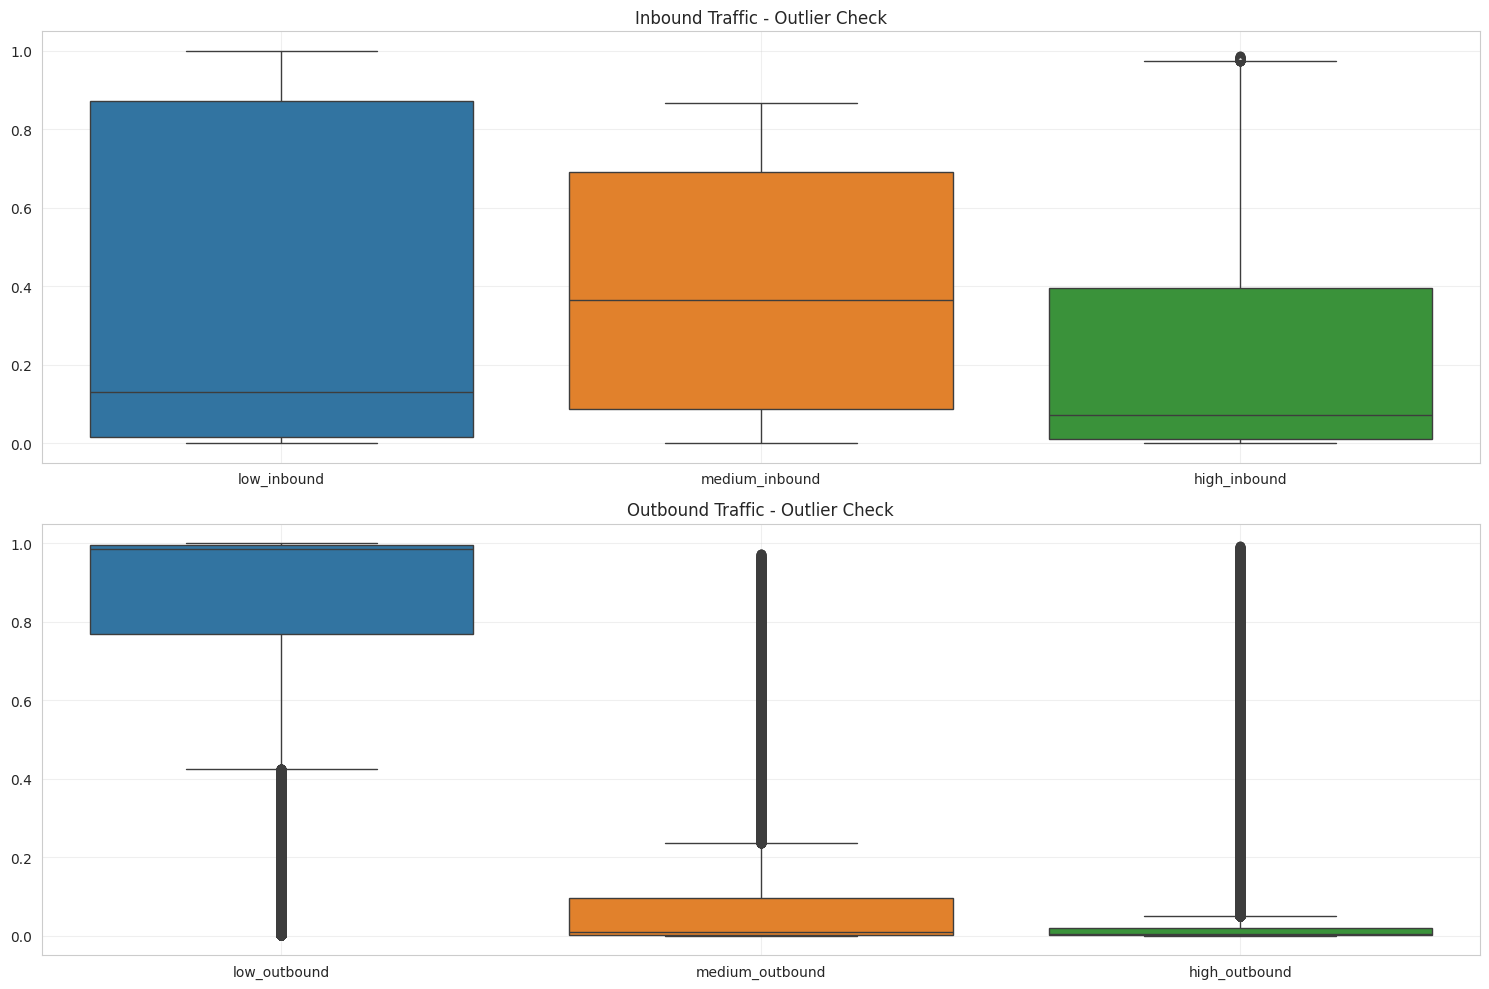

In [42]:
# 2.5: Check for outliers and unusual data points
plt.figure(figsize=(15, 10))

# Inbound traffic
plt.subplot(2, 1, 1)
sns.boxplot(data=data_indexed[traffic_cols[:3]])
plt.title('Inbound Traffic - Outlier Check')
plt.grid(True, alpha=0.3)

# Outbound traffic
plt.subplot(2, 1, 2)
sns.boxplot(data=data_indexed[traffic_cols[3:]])
plt.title('Outbound Traffic - Outlier Check')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# 2.6: Check for sudden unusual changes
for col in traffic_cols:
    # Calculate absolute changes
    changes = data_indexed[col].diff().abs()

    # Look for unusually large changes (potential errors)
    threshold = changes.mean() + 3 * changes.std()  # 3 standard deviations above mean
    large_changes = changes[changes > threshold]

    if len(large_changes) > 0:
        print(f"\nFound {len(large_changes)} unusually large changes in {col}")
        print(f"Threshold: {threshold:.4f}")
        print("Top 3 largest changes:")
        for time, change in large_changes.nlargest(3).items():
            value_before = data_indexed.loc[time][col] - change if not np.isnan(data_indexed.loc[time][col] - change) else "N/A"
            value_after = data_indexed.loc[time][col]
            print(f"{time}: Change of {change:.4f} (From {value_before} to {value_after:.4f})")


Found 870 unusually large changes in high_inbound
Threshold: 0.7434
Top 3 largest changes:
2025-03-07 07:56:16: Change of 0.9521 (From -0.93955704 to 0.0126)
2025-03-10 07:56:09: Change of 0.9437 (From 0.0010310512000000216 to 0.9447)
2025-03-07 06:34:06: Change of 0.9371 (From 0.0015651236000000512 to 0.9387)

Found 459 unusually large changes in medium_outbound
Threshold: 0.8940
Top 3 largest changes:
2025-03-03 11:37:14: Change of 0.9665 (From 0.005066659300000054 to 0.9716)
2025-02-28 11:34:44: Change of 0.9635 (From -0.955317402 to 0.0082)
2025-02-28 14:42:29: Change of 0.9624 (From -0.9615985509 to 0.0008)

Found 2844 unusually large changes in high_outbound
Threshold: 0.8113
Top 3 largest changes:
2025-02-28 15:31:24: Change of 0.9928 (From 0.001662420599999992 to 0.9945)
2025-03-04 07:18:24: Change of 0.9883 (From -0.9865182518000001 to 0.0017)
2025-02-22 16:31:10: Change of 0.9875 (From 0.0012110268999999674 to 0.9887)


### ***Data Quality Assessment Summary***
Based on our initial examination:

1. **Data Completeness**:
   - Complete dataset with 75,655 entries
   - 7 columns: timestamp and 6 traffic-related features
   - No missing values in any columns
   - All features are in appropriate data types (datetime64 and float64)

2. **Time Characteristics**:
   - Data spans 17 days (Feb 21, 2025 - Mar 10, 2025)
   - Typical interval between records is 10 seconds (median)
   - Average interval is ~20 seconds (mean)
   - One duplicate timestamp found

3. **Data Normalization**:
   - Data is properly normalized
   - Inbound sum: mean ≈ 1.0000 (min: 0.9999, max: 1.0000)
   - Outbound sum: mean ≈ 1.0000 (min: 0.9999, max: 1.0000)

4. **Data Continuity**:
   - 71 significant gaps (>60 seconds) identified
   - Largest gap is ~7.5 hours (447.98 minutes)
   - Pattern of ~7-hour gaps (420-421 minutes) occurring at around 5:00 AM
   - These gaps likely represent planned system downtime

5. **Outliers and Anomalies**:
   - Significant sudden changes detected in traffic levels:
     * High inbound: 870 unusual changes
     * Medium outbound: 459 unusual changes
     * High outbound: 2,844 unusual changes
   - Maximum changes are substantial (>0.95 in magnitude)
   - Most extreme changes occur during morning hours (6:00-8:00 AM)

6. **Potential Issues**:
   - Regular system downtime around 5:00 AM needs to be considered in analysis
   - Large number of sudden changes in high outbound traffic might need investigation
   - One duplicate timestamp needs to be handled
   - Some negative values found in the changes (indicating potential data recording issues)

These findings suggest we should focus on:
- Handling the regular morning gaps in preprocessing
- Investigating the validity of sudden traffic changes
- Removing the duplicate timestamp
- Adding flags for post-downtime periods

Let's proceed with exploratory data analysis to understand the patterns in our data.

## ***IV. Exploratory Data Analysis (EDA)***

In [44]:
# Create a copy of the data for analysis with timestamp as index
data = df.copy()
data.set_index('timestamp', inplace=True)

# Create output directory for visualizations
import os
output_dir = "visualizations"
os.makedirs(output_dir, exist_ok=True)

# Add necessary columns for analysis if not already present
if 'day_of_week' not in data.columns:
    data['day_of_week'] = data.index.dayofweek
if 'hour' not in data.columns:
    data['hour'] = data.index.hour
if 'is_weekend' not in data.columns:
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

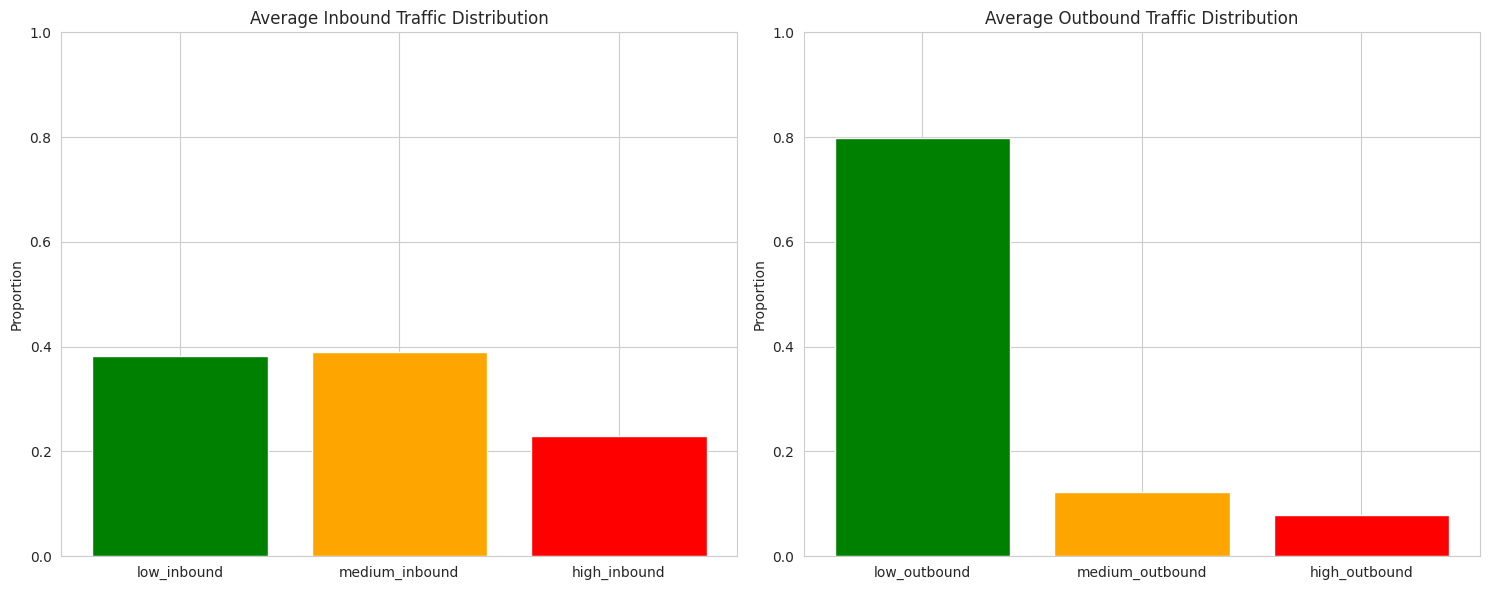

In [45]:
# 3.1: Traffic Distribution
# Plot traffic distribution for inbound and outbound directions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Inbound traffic distribution
inbound_data = data[['low_inbound', 'medium_inbound', 'high_inbound']].mean()
axes[0].bar(inbound_data.index, inbound_data.values, color=['green', 'orange', 'red'])
axes[0].set_title('Average Inbound Traffic Distribution')
axes[0].set_ylabel('Proportion')
axes[0].set_ylim(0, 1)

# Outbound traffic distribution
outbound_data = data[['low_outbound', 'medium_outbound', 'high_outbound']].mean()
axes[1].bar(outbound_data.index, outbound_data.values, color=['green', 'orange', 'red'])
axes[1].set_title('Average Outbound Traffic Distribution')
axes[1].set_ylabel('Proportion')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'traffic_distribution.png'))
plt.show()

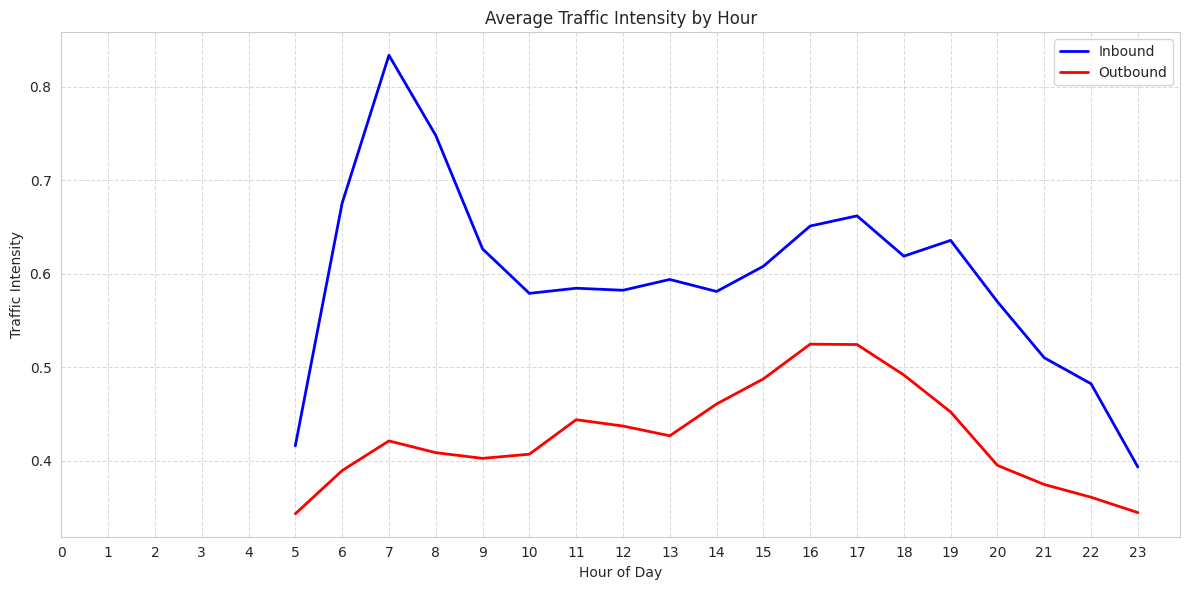

In [47]:
# 3.2: Hourly Traffic Patterns
# Calculate inbound and outbound intensity if not already present
if 'inbound_intensity' not in data.columns:
    data['inbound_intensity'] = (
        data['low_inbound'] * 1 +
        data['medium_inbound'] * 2 +
        data['high_inbound'] * 3
    ) / 3

    data['outbound_intensity'] = (
        data['low_outbound'] * 1 +
        data['medium_outbound'] * 2 +
        data['high_outbound'] * 3
    ) / 3

# Group by hour and calculate mean for traffic intensity
hourly_data = data.groupby('hour')[['inbound_intensity', 'outbound_intensity']].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['inbound_intensity'], 'b-', label='Inbound', linewidth=2)
plt.plot(hourly_data.index, hourly_data['outbound_intensity'], 'r-', label='Outbound', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Intensity')
plt.title('Average Traffic Intensity by Hour')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'hourly_traffic_patterns.png'))
plt.show()

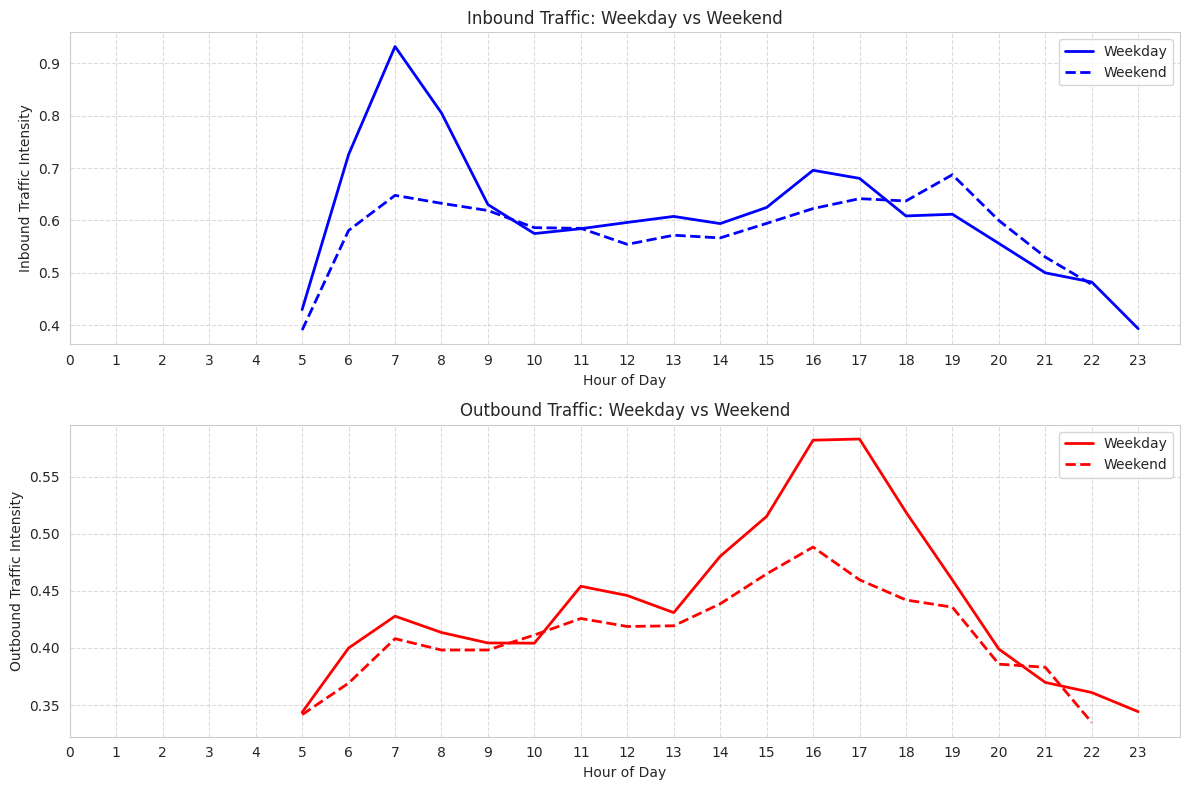

In [48]:
# 3.3: Weekday vs Weekend Comparison
# Group by hour and weekend flag, then calculate mean
grouped_data = data.groupby(['hour', 'is_weekend'])[['inbound_intensity', 'outbound_intensity']].mean().reset_index()

# Separate weekday and weekend data
weekday_data = grouped_data[grouped_data['is_weekend'] == 0]
weekend_data = grouped_data[grouped_data['is_weekend'] == 1]

plt.figure(figsize=(12, 8))

# Plot inbound traffic
plt.subplot(2, 1, 1)
plt.plot(weekday_data['hour'], weekday_data['inbound_intensity'], 'b-', label='Weekday', linewidth=2)
plt.plot(weekend_data['hour'], weekend_data['inbound_intensity'], 'b--', label='Weekend', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Inbound Traffic Intensity')
plt.title('Inbound Traffic: Weekday vs Weekend')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Plot outbound traffic
plt.subplot(2, 1, 2)
plt.plot(weekday_data['hour'], weekday_data['outbound_intensity'], 'r-', label='Weekday', linewidth=2)
plt.plot(weekend_data['hour'], weekend_data['outbound_intensity'], 'r--', label='Weekend', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Outbound Traffic Intensity')
plt.title('Outbound Traffic: Weekday vs Weekend')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'weekday_weekend_comparison.png'))
plt.show()

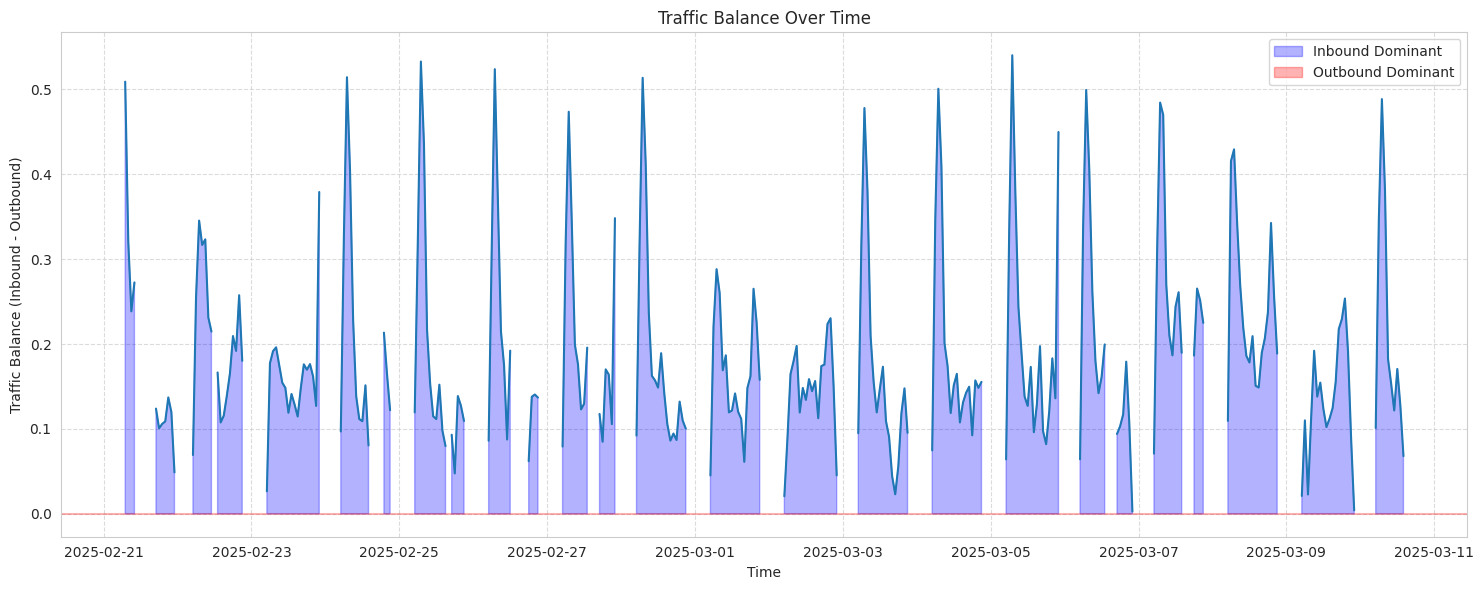

In [49]:
# 3.4: Traffic Balance
# Calculate traffic balance if not already present
if 'traffic_balance' not in data.columns:
    data['traffic_balance'] = data['inbound_intensity'] - data['outbound_intensity']

# Resample to hourly data for better visualization
hourly_balance = data['traffic_balance'].resample('1h').mean()

plt.figure(figsize=(15, 6))
plt.plot(hourly_balance.index, hourly_balance.values, linewidth=1.5)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Traffic Balance (Inbound - Outbound)')
plt.title('Traffic Balance Over Time')
plt.grid(True, linestyle='--', alpha=0.7)

# Add shaded regions for positive (inbound dominant) and negative (outbound dominant)
plt.fill_between(hourly_balance.index, hourly_balance.values, 0,
                 where=(hourly_balance.values > 0),
                 color='blue', alpha=0.3, label='Inbound Dominant')
plt.fill_between(hourly_balance.index, hourly_balance.values, 0,
                 where=(hourly_balance.values < 0),
                 color='red', alpha=0.3, label='Outbound Dominant')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'traffic_balance.png'))
plt.show()

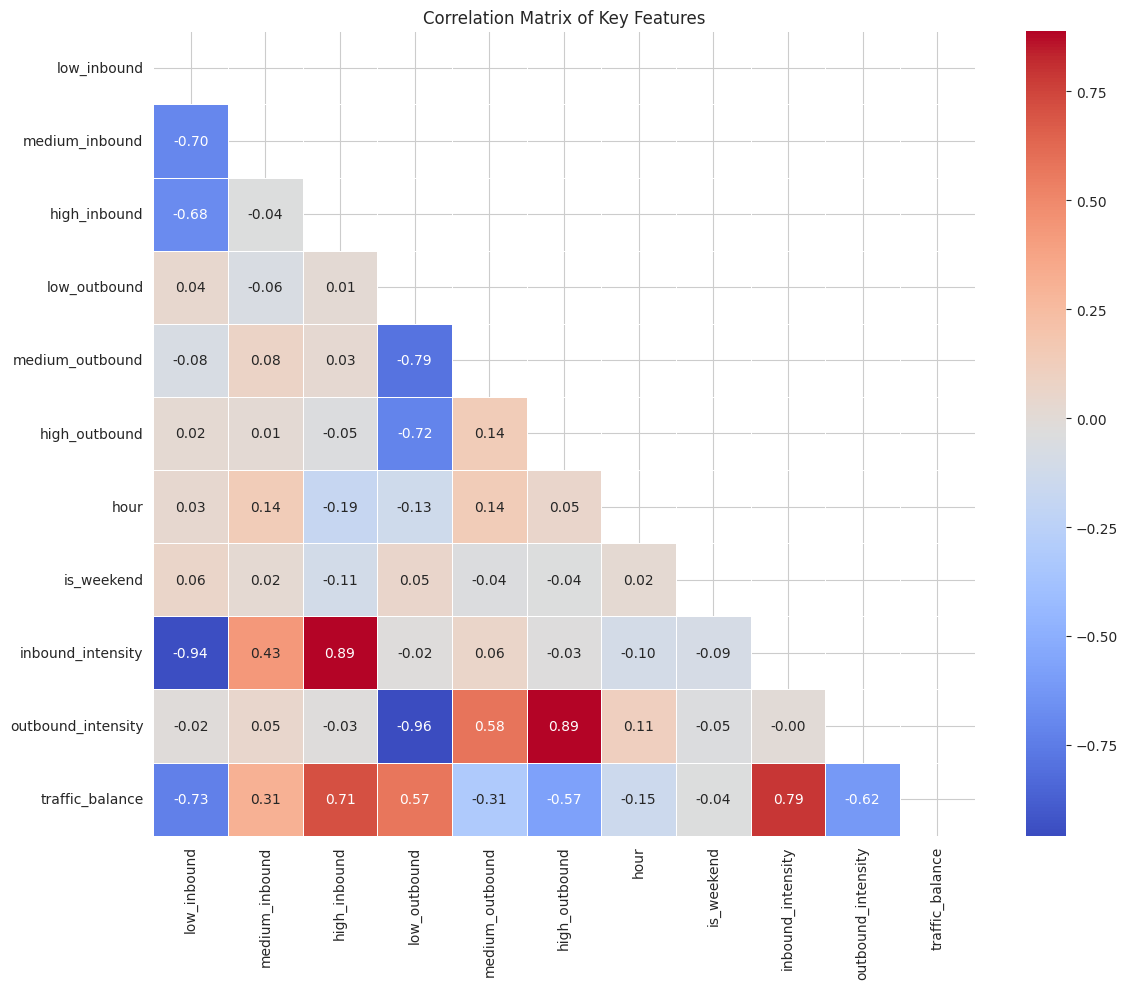

In [50]:
# 3.5: Correlation Matrix
# Select key features for correlation analysis
key_features = [
    'low_inbound', 'medium_inbound', 'high_inbound',
    'low_outbound', 'medium_outbound', 'high_outbound',
    'hour', 'is_weekend', 'inbound_intensity', 'outbound_intensity', 'traffic_balance'
]

if 'is_peak_morning' in data.columns:
    key_features.extend(['is_peak_morning', 'is_peak_evening'])

# Calculate correlation matrix
corr_matrix = data[key_features].corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'))
plt.show()

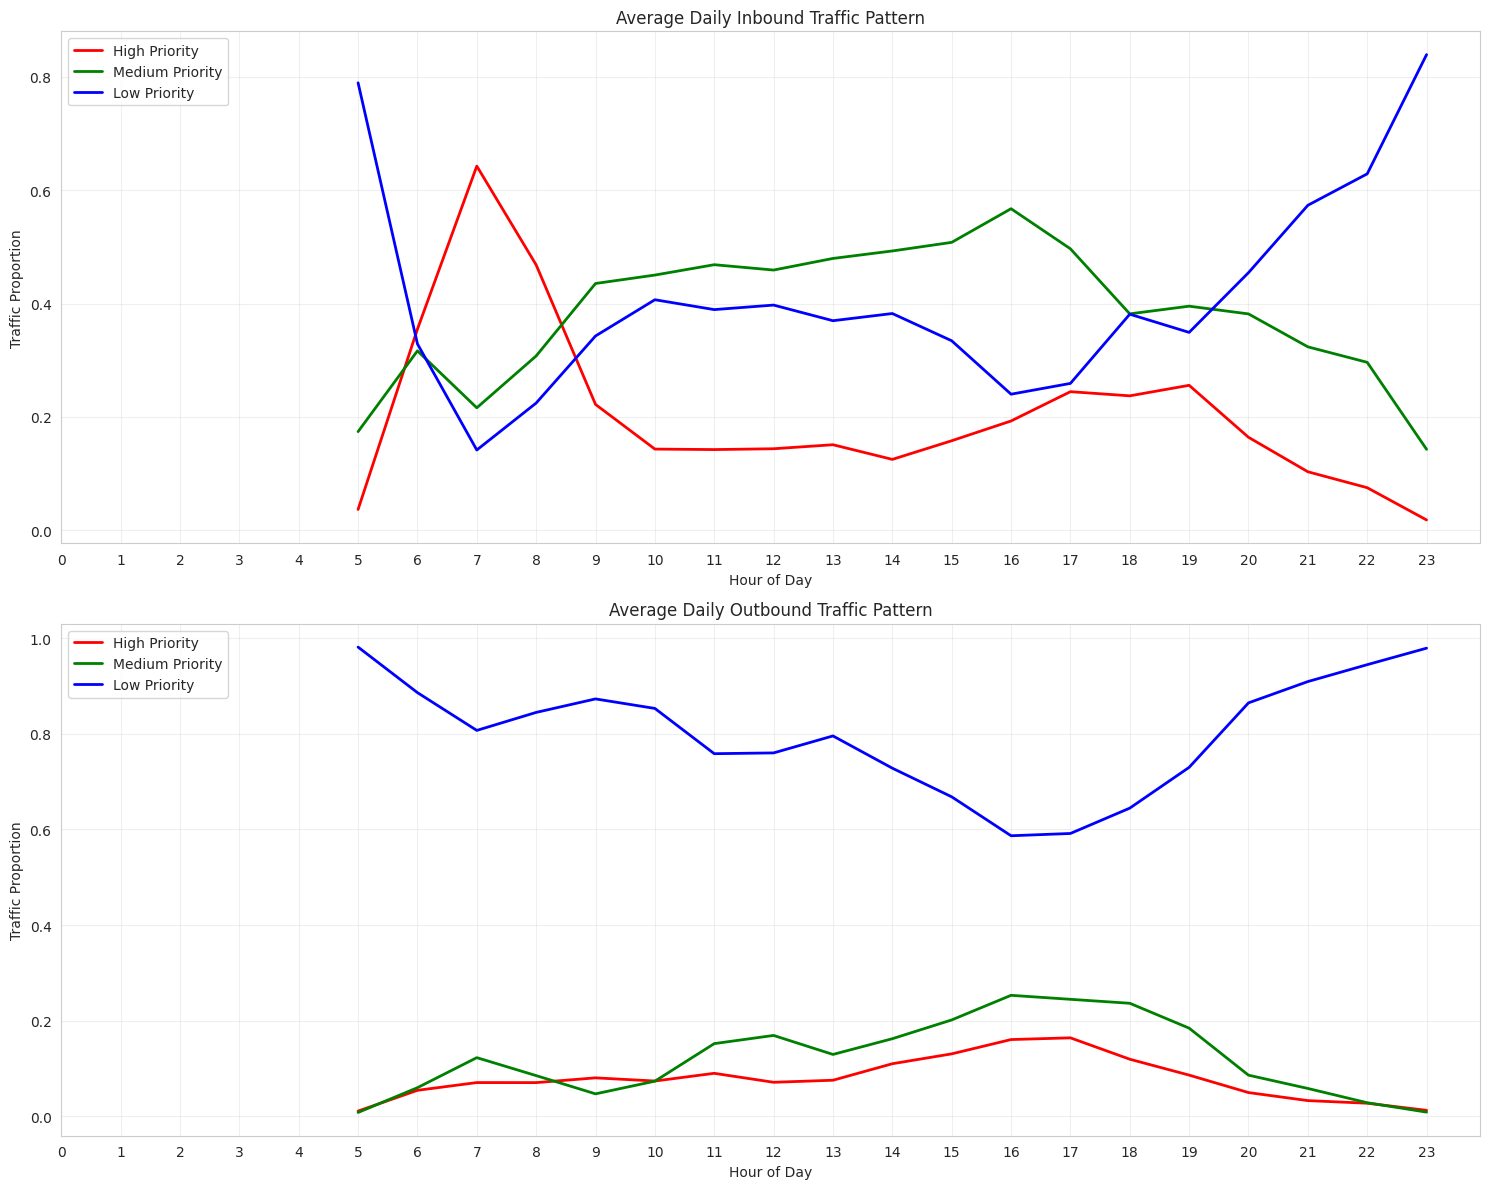

In [51]:
# 3.6: Daily Traffic Patterns by Priority
# Plot daily patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Inbound traffic
ax1.plot(data.groupby('hour')['high_inbound'].mean(), 'r-', label='High Priority', linewidth=2)
ax1.plot(data.groupby('hour')['medium_inbound'].mean(), 'g-', label='Medium Priority', linewidth=2)
ax1.plot(data.groupby('hour')['low_inbound'].mean(), 'b-', label='Low Priority', linewidth=2)
ax1.set_title('Average Daily Inbound Traffic Pattern')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Traffic Proportion')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24))

# Outbound traffic
ax2.plot(data.groupby('hour')['high_outbound'].mean(), 'r-', label='High Priority', linewidth=2)
ax2.plot(data.groupby('hour')['medium_outbound'].mean(), 'g-', label='Medium Priority', linewidth=2)
ax2.plot(data.groupby('hour')['low_outbound'].mean(), 'b-', label='Low Priority', linewidth=2)
ax2.set_title('Average Daily Outbound Traffic Pattern')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Traffic Proportion')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'daily_patterns.png'), dpi=300, bbox_inches='tight')
plt.show()

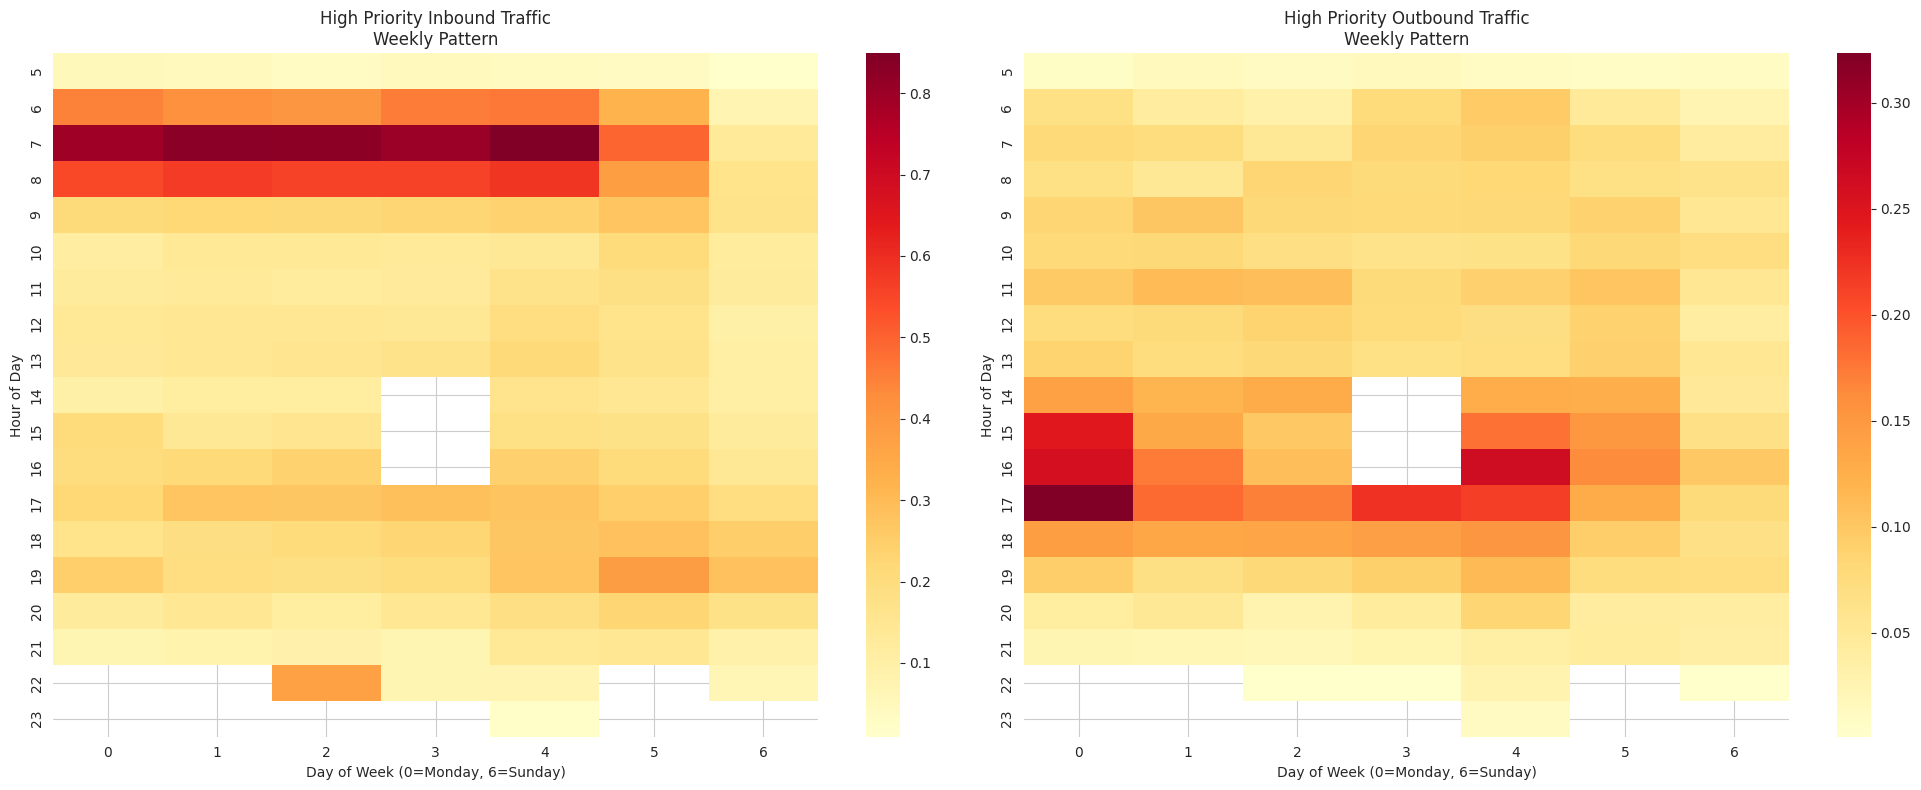

In [52]:
# 3.7: Weekly Traffic Patterns Heatmap
# Create weekly heatmaps for high priority traffic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Inbound heatmap
pivot_in = data.pivot_table(
    values='high_inbound',
    index='hour',
    columns='day_of_week',
    aggfunc='mean'
)
sns.heatmap(pivot_in, cmap='YlOrRd', ax=ax1)
ax1.set_title('High Priority Inbound Traffic\nWeekly Pattern')
ax1.set_xlabel('Day of Week (0=Monday, 6=Sunday)')
ax1.set_ylabel('Hour of Day')

# Outbound heatmap
pivot_out = data.pivot_table(
    values='high_outbound',
    index='hour',
    columns='day_of_week',
    aggfunc='mean'
)
sns.heatmap(pivot_out, cmap='YlOrRd', ax=ax2)
ax2.set_title('High Priority Outbound Traffic\nWeekly Pattern')
ax2.set_xlabel('Day of Week (0=Monday, 6=Sunday)')
ax2.set_ylabel('Hour of Day')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'weekly_patterns.png'), dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

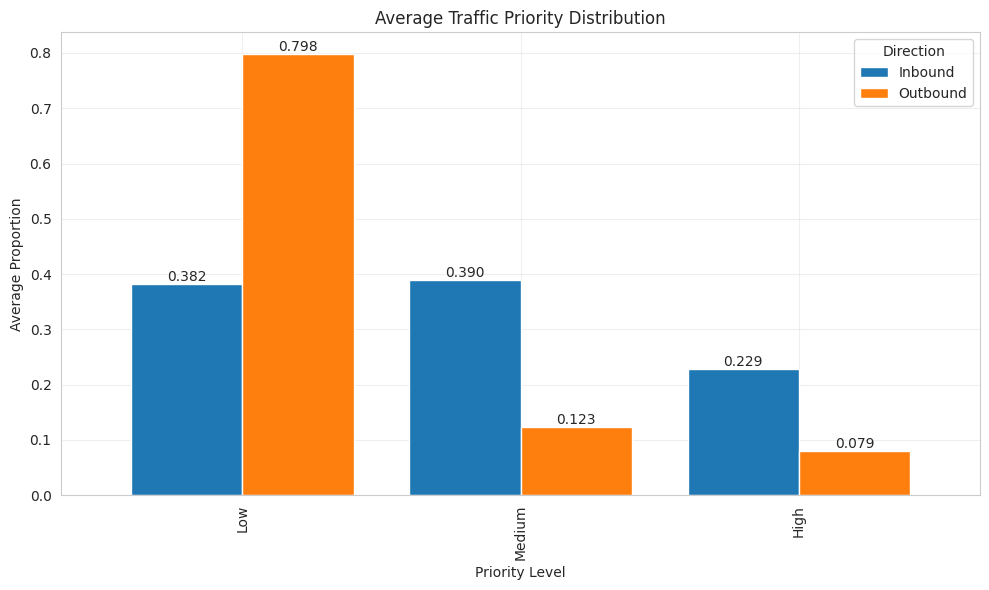

In [53]:
# 3.8: Priority Distribution Analysis
# Calculate traffic proportions
for direction in ['inbound', 'outbound']:
    total = data[f'low_{direction}'] + data[f'medium_{direction}'] + data[f'high_{direction}']
    data[f'{direction}_low_prop'] = data[f'low_{direction}'] / total
    data[f'{direction}_mid_prop'] = data[f'medium_{direction}'] / total
    data[f'{direction}_high_prop'] = data[f'high_{direction}'] / total

# Calculate and plot average proportions
avg_props = pd.DataFrame({
    'Inbound': [
        data['inbound_low_prop'].mean(),
        data['inbound_mid_prop'].mean(),
        data['inbound_high_prop'].mean()
    ],
    'Outbound': [
        data['outbound_low_prop'].mean(),
        data['outbound_mid_prop'].mean(),
        data['outbound_high_prop'].mean()
    ]
}, index=['Low', 'Medium', 'High'])

plt.figure(figsize=(10, 6))
ax = avg_props.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Average Traffic Priority Distribution')
plt.xlabel('Priority Level')
plt.ylabel('Average Proportion')
plt.legend(title='Direction')
plt.grid(True, alpha=0.3)

for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'priority_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

### ***EDA Summary***
Based on our exploratory analysis, we've found:

1. **Traffic Distribution**:
   - Inbound traffic is fairly balanced across priorities (Low: 38%, Medium: 39%, High: 23%)
   - Outbound traffic is heavily skewed towards low priority (Low: 80%, Medium: 12%, High: 8%)
   - Clear asymmetry between inbound and outbound traffic patterns

2. **Hourly Patterns**:
   - Morning peak (7-8 AM) shows highest inbound intensity (~0.85)
   - Evening peak (16-17 PM) shows highest outbound intensity (~0.52)
   - Inbound traffic consistently higher than outbound throughout the day
   - Low activity period between 0-5 AM (likely system downtime)

3. **Weekday vs Weekend Differences**:
   - Weekdays show stronger morning peak for inbound traffic
   - Weekend inbound patterns are more evenly distributed
   - Weekday outbound traffic shows clear evening peak (16-18 PM)
   - Weekend outbound traffic is consistently lower than weekdays
   - Both patterns converge in late evening hours

4. **Traffic Balance Trends**:
   - Consistently inbound-dominant (positive balance)
   - Regular daily spikes in morning hours
   - No significant outbound-dominant periods (no negative balance)
   - Pattern repeats with similar magnitude across days

5. **Feature Correlations**:
   - Strong negative correlation (-0.70) between low and medium inbound traffic
   - Strong negative correlation (-0.79) between low and medium outbound traffic
   - High inbound traffic strongly correlated (0.89) with inbound intensity
   - High outbound traffic strongly correlated (0.89) with outbound intensity
   - Weak correlations with hour and weekend features, suggesting time-independent patterns

6. **Priority Distribution**:
   - Daily inbound patterns show priority shifts:
     * High priority peaks in morning (7-8 AM)
     * Medium priority dominates midday
     * Low priority increases in late evening
   - Daily outbound patterns show:
     * Consistently high low-priority traffic
     * Medium and high priorities peak in evening hours
   - Weekly patterns show:
     * Strong morning high-priority inbound traffic on weekdays
     * Evening high-priority outbound traffic pattern
     * Clear weekday/weekend differences

These insights suggest we should:
- Handle the 0-5 AM period separately due to system downtime
- Consider different models for weekday/weekend traffic
- Pay special attention to morning and evening peak transitions
- Account for the asymmetric distribution between inbound and outbound traffic

## ***V. Data Preprocessing***

In [54]:
# Start with a fresh copy of the original data
processed_df = df.copy()

# Convert timestamp to datetime if not already done
processed_df['timestamp'] = pd.to_datetime(processed_df['timestamp'])

# 4.1: Handle duplicate timestamps
if duplicates.any():
    print(f"Handling {duplicates.sum()} duplicate timestamps...")
    processed_df = processed_df.drop_duplicates(subset=['timestamp'], keep='first')

Handling 1 duplicate timestamps...


In [55]:
# 4.2: Set timestamp as index
processed_df.set_index('timestamp', inplace=True)
processed_df.sort_index(inplace=True)

# Handle downtimes and missing data
time_diffs = processed_df.index.to_series().diff().dt.total_seconds()
gaps = time_diffs[time_diffs > 60]  # Gaps larger than 1 minute

processed_df['is_after_downtime'] = False
if len(gaps) > 0:
    print(f"Flagging {len(gaps)} records after downtimes...")
    for timestamp in gaps.index:
        processed_df.loc[timestamp, 'is_after_downtime'] = True

Flagging 71 records after downtimes...


In [56]:
# 4.3: Extract time-based features
processed_df['hour'] = processed_df.index.hour
processed_df['minute'] = processed_df.index.minute
processed_df['day_of_week'] = processed_df.index.dayofweek
processed_df['is_weekend'] = processed_df['day_of_week'].isin([5, 6]).astype(int)
processed_df['is_peak_morning'] = ((processed_df['hour'] >= 7) & (processed_df['hour'] <= 9)).astype(int)
processed_df['is_peak_evening'] = ((processed_df['hour'] >= 16) & (processed_df['hour'] <= 18)).astype(int)

In [57]:
# 4.4: Calculate traffic metrics
# Traffic totals
processed_df['inbound_total'] = processed_df['low_inbound'] + processed_df['medium_inbound'] + processed_df['high_inbound']
processed_df['outbound_total'] = processed_df['low_outbound'] + processed_df['medium_outbound'] + processed_df['high_outbound']

# Normalize if needed (if not already normalized)
if not is_normalized:
    print("Normalizing traffic values...")
    for direction in ['inbound', 'outbound']:
        total_col = f"{direction}_total"
        for level in ['low', 'medium', 'high']:
            col = f"{level}_{direction}"
            processed_df[col] = processed_df[col] / processed_df[total_col]

    # Recalculate totals
    processed_df['inbound_total'] = processed_df['low_inbound'] + processed_df['medium_inbound'] + processed_df['high_inbound']
    processed_df['outbound_total'] = processed_df['low_outbound'] + processed_df['medium_outbound'] + processed_df['high_outbound']

# Traffic direction ratio
processed_df['inbound_outbound_ratio'] = processed_df['inbound_total'] / processed_df['outbound_total'].replace(0, np.nan)
processed_df['inbound_outbound_ratio'] = processed_df['inbound_outbound_ratio'].fillna(1.0)

# Traffic intensity
processed_df['inbound_intensity'] = (
    processed_df['low_inbound'] * 1 +
    processed_df['medium_inbound'] * 2 +
    processed_df['high_inbound'] * 3
) / 3

processed_df['outbound_intensity'] = (
    processed_df['low_outbound'] * 1 +
    processed_df['medium_outbound'] * 2 +
    processed_df['high_outbound'] * 3
) / 3

# Traffic balance
processed_df['traffic_balance'] = processed_df['inbound_intensity'] - processed_df['outbound_intensity']

In [58]:
# 4.5: Create multi-resolution features
# Define columns for rolling window calculations
traffic_cols = [
    'low_inbound', 'medium_inbound', 'high_inbound',
    'low_outbound', 'medium_outbound', 'high_outbound',
    'inbound_intensity', 'outbound_intensity', 'traffic_balance'
]

# 5-minute rolling window
for col in traffic_cols:
    processed_df[f'{col}_5min_mean'] = processed_df[col].rolling('5min').mean()
    processed_df[f'{col}_5min_std'] = processed_df[col].rolling('5min').std()

# 15-minute rolling window
for col in traffic_cols:
    processed_df[f'{col}_15min_mean'] = processed_df[col].rolling('15min').mean()
    processed_df[f'{col}_15min_std'] = processed_df[col].rolling('15min').std()

# 1-hour rolling window
for col in traffic_cols:
    processed_df[f'{col}_1hour_mean'] = processed_df[col].rolling('1h').mean()
    processed_df[f'{col}_1hour_std'] = processed_df[col].rolling('1h').std()

# Fill NaN values created by rolling windows
rolling_cols = [col for col in processed_df.columns if any(x in col for x in ['_5min_', '_15min_', '_1hour_'])]
processed_df[rolling_cols] = processed_df[rolling_cols].bfill().ffill()

In [59]:
# 4.6: Display the final preprocessed data
print(f"Final preprocessed data shape: {processed_df.shape}")
print(f"Number of features: {len(processed_df.columns)}")
processed_df.head()

Final preprocessed data shape: (75654, 75)
Number of features: 75


,low_inbound,medium_inbound,high_inbound,low_outbound,medium_outbound,high_outbound,inbound_sum,outbound_sum,is_after_downtime,hour,minute,day_of_week,is_weekend,is_peak_morning,is_peak_evening,inbound_total,outbound_total,inbound_outbound_ratio,inbound_intensity,outbound_intensity,traffic_balance,low_inbound_5min_mean,low_inbound_5min_std,medium_inbound_5min_mean,medium_inbound_5min_std,high_inbound_5min_mean,high_inbound_5min_std,low_outbound_5min_mean,low_outbound_5min_std,medium_outbound_5min_mean,medium_outbound_5min_std,high_outbound_5min_mean,high_outbound_5min_std,inbound_intensity_5min_mean,inbound_intensity_5min_std,outbound_intensity_5min_mean,outbound_intensity_5min_std,traffic_balance_5min_mean,traffic_balance_5min_std,low_inbound_15min_mean,low_inbound_15min_std,medium_inbound_15min_mean,medium_inbound_15min_std,high_inbound_15min_mean,high_inbound_15min_std,low_outbound_15min_mean,low_outbound_15min_std,medium_outbound_15min_mean,medium_outbound_15min_std,high_outbound_15min_mean,high_outbound_15min_std,inbound_intensity_15min_mean,inbound_intensity_15min_std,outbound_intensity_15min_mean,outbound_intensity_15min_std,traffic_balance_15min_mean,traffic_balance_15min_std,low_inbound_1hour_mean,low_inbound_1hour_std,medium_inbound_1hour_mean,medium_inbound_1hour_std,high_inbound_1hour_mean,high_inbound_1hour_std,low_outbound_1hour_mean,low_outbound_1hour_std,medium_outbound_1hour_mean,medium_outbound_1hour_std,high_outbound_1hour_mean,high_outbound_1hour_std,inbound_intensity_1hour_mean,inbound_intensity_1hour_std,outbound_intensity_1hour_mean,outbound_intensity_1hour_std,traffic_balance_1hour_mean,traffic_balance_1hour_std
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-21 07:48:09,0.000827,0.058200,0.940973,0.989017,0.008932,0.002052,1.0,1.0,False,7,48,4,0,1,0,1.0,1.0,1.0,0.980049,0.337678,0.642370,0.000827,0.000293,0.058200,0.017362,0.940973,0.017656,0.989017,0.004992,0.008932,0.004344,0.002052,0.000648,0.980049,0.005983,0.337678,0.001880,0.642370,0.007863,0.000827,0.000293,0.058200,0.017362,0.940973,0.017656,0.989017,0.004992,0.008932,0.004344,0.002052,0.000648,0.980049,0.005983,0.337678,0.001880,0.642370,0.007863,0.000827,0.000293,0.058200,0.017362,0.940973,0.017656,0.989017,0.004992,0.008932,0.004344,0.002052,0.000648,0.980049,0.005983,0.337678,0.001880,0.642370,0.007863
2025-02-21 07:48:19,0.000412,0.033646,0.965942,0.996076,0.002788,0.001136,1.0,1.0,False,7,48,4,0,1,0,1.0,1.0,1.0,0.988510,0.335020,0.653490,0.000619,0.000293,0.045923,0.017362,0.953458,0.017656,0.992546,0.004992,0.005860,0.004344,0.001594,0.000648,0.984279,0.005983,0.336349,0.001880,0.647930,0.007863,0.000619,0.000293,0.045923,0.017362,0.953458,0.017656,0.992546,0.004992,0.005860,0.004344,0.001594,0.000648,0.984279,0.005983,0.336349,0.001880,0.647930,0.007863,0.000619,0.000293,0.045923,0.017362,0.953458,0.017656,0.992546,0.004992,0.005860,0.004344,0.001594,0.000648,0.984279,0.005983,0.336349,0.001880,0.647930,0.007863
2025-02-21 07:48:29,0.003714,0.266212,0.730074,0.261669,0.670311,0.068020,1.0,1.0,False,7,48,4,0,1,0,1.0,1.0,1.0,0.908787,0.602117,0.306670,0.001651,0.001799,0.119353,0.127775,0.878997,0.129573,0.748920,0.421987,0.227344,0.383634,0.023736,0.038354,0.959115,0.043790,0.424938,0.153447,0.534177,0.197105,0.001651,0.001799,0.119353,0.127775,0.878997,0.129573,0.748920,0.421987,0.227344,0.383634,0.023736,0.038354,0.959115,0.043790,0.424938,0.153447,0.534177,0.197105,0.001651,0.001799,0.119353,0.127775,0.878997,0.129573,0.748920,0.421987,0.227344,0.383634,0.023736,0.038354,0.959115,0.043790,0.424938,0.153447,0.534177,0.197105
2025-02-21 07:48:44,0.001004,0.063582,0.935414,0.690030,0.267154,0.042816,1.0,1.0,False,7,48,4,0,1,0,1.0,1.0,1.0,0.978137,0.450929,0.527208,0.001489,0.001504,0.105410,0.107990,0.893101,0.109492,0.734198,0.345807,0.237296,0.313867,0.028506,0.032737,0.963871,0.036998,0.431436,0.125961,0.532435,0.160973,0.001489,0.001504,0.105410,0.107990,0.893101,0.109492,0.734198,0.345807

In [60]:
# Reset index to make timestamp a column again
final_df = processed_df.reset_index()

# Save to CSV
output_filename = 'traffic_preprocessed_data.csv'
final_df.to_csv(output_filename, index=False)
print(f"Saved preprocessed data to {output_filename}")
print("Preprocessing complete!")

Saved preprocessed data to traffic_preprocessed_data.csv
Preprocessing complete!
